In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Dict, Any, Tuple, List, Union

res_sparsity = 0

def calculate_threshold_from_sparsity(
    bin_edges: torch.Tensor,
    histogram_counts: torch.Tensor,
    target_sparsity: float,
    verbose: bool = False
) -> float:
    """
    根据目标稀疏度计算阈值
    
    Args:
        bin_edges: 直方图区间边界
        histogram_counts: 各区间的计数
        target_sparsity: 目标稀疏度 (0-1之间)
        verbose: 是否打印调试信息
        
    Returns:
        threshold: 对应稀疏度的阈值
    """
    if not (0 <= target_sparsity <= 1):
        raise ValueError(f"target_sparsity must be between 0 and 1, got {target_sparsity}")
    
    # 计算累积概率
    total_count = histogram_counts.sum()
    normalized_counts = histogram_counts / total_count
    cumulative_prob = torch.cumsum(normalized_counts, dim=0)
    
    if verbose:
        print(f"Total count: {total_count}")
        print(f"Target sparsity: {target_sparsity:.2%}")
    
    # 使用 searchsorted 找到累积概率刚好超过目标稀疏度的位置
    target_cumulative_prob = torch.tensor(target_sparsity)
    threshold_idx = torch.searchsorted(cumulative_prob, target_cumulative_prob, right=False)
    
    # 边界检查
    threshold_idx = torch.clamp(threshold_idx, 0, len(bin_edges) - 2)
    
    # 获取对应的阈值
    threshold = bin_edges[threshold_idx].item()
    
    if verbose:
        actual_sparsity = cumulative_prob[threshold_idx].item()
        print(f"Threshold index: {threshold_idx}")
        print(f"Calculated threshold: {threshold:.6f}")
        print(f"Actual sparsity at threshold: {actual_sparsity:.2%}")
    
    return threshold


def plot_all_experts_histogram(
    act_dict: Dict[int, Dict[int, Any]],
    layer_indices: Optional[List[int]] = None,
    expert_indices: Optional[List[int]] = None,
    threshold: Optional[float] = None,
    target_sparsity: Optional[float] = None,
    within_color: str = "#227CF6",
    outside_color: str = "#FF6B35", 
    within_alpha: float = 0.5,
    outside_alpha: float = 0.9,
    threshold_color: str = "#FF0000",
    threshold_alpha: float = 0.8,
    zero_line_alpha: float = 0.3,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (20, 15),
    show_legend: bool = True,
    show_plot: bool = True,
    title: Optional[str] = None,
    xlabel: str = "Activation Value",
    ylabel: str = "Normalized Count",
    bin_edges_idx: int = 0,
    histogram_counts_idx: int = 2,
    max_cols: int = 8,
    show_threshold_lines: bool = True,
    verbose: bool = True
) -> Tuple[plt.Figure, np.ndarray]:
    """
    绘制所有层所有专家的激活值直方图，支持基于稀疏度的动态阈值
    
    Args:
        act_dict: 三层结构的字典 [layer][expert][data]
        layer_indices: 要绘制的层索引列表，如果为None则绘制所有层
        expert_indices: 要绘制的专家索引列表，如果为None则绘制所有专家
        threshold: 固定阈值，如果提供则忽略target_sparsity
        target_sparsity: 目标稀疏度 (0-1)，用于动态计算阈值
        within_color: 阈值内激活值的颜色
        outside_color: 阈值外激活值的颜色
        within_alpha: 阈值内激活值的透明度
        outside_alpha: 阈值外激活值的透明度
        threshold_color: 阈值线的颜色
        threshold_alpha: 阈值线的透明度
        zero_line_alpha: 零线的透明度
        xlim: x轴显示范围
        ylim: y轴显示范围
        figsize: 图片大小
        show_legend: 是否显示图例
        show_plot: 是否显示图片
        title: 总标题
        xlabel: x轴标签
        ylabel: y轴标签
        bin_edges_idx: bin_edges在数据中的索引
        histogram_counts_idx: histogram_counts在数据中的索引
        max_cols: 每行最大列数
        show_threshold_lines: 是否显示阈值线
        verbose: 是否打印调试信息
        
    Returns:
        fig, axes: matplotlib的图形和轴对象数组
    """
    
    # 参数验证
    if threshold is None and target_sparsity is None:
        threshold = 0.0  # 默认阈值
    elif threshold is not None and target_sparsity is not None:
        print("Warning: Both threshold and target_sparsity provided. Using fixed threshold.")
    
    # 确定要绘制的层
    if layer_indices is None:
        layer_indices = sorted(act_dict.keys())
    else:
        missing_layers = [idx for idx in layer_indices if idx not in act_dict]
        if missing_layers:
            raise ValueError(f"Layers not found in act_dict: {missing_layers}")
    
    # 统计总的专家数量和层数
    total_experts = 0
    layer_expert_count = {}
    expert_list = []  # 存储 (layer_idx, expert_idx) 元组
    
    for layer_idx in layer_indices:
        layer_data = act_dict[layer_idx]
        if isinstance(layer_data, dict):
            # 确定要绘制的专家
            current_expert_indices = expert_indices if expert_indices is not None else sorted(layer_data.keys())
            
            # 验证专家索引是否存在
            missing_experts = [idx for idx in current_expert_indices if idx not in layer_data]
            if missing_experts:
                print(f"Warning: Experts {missing_experts} not found in layer {layer_idx}")
                current_expert_indices = [idx for idx in current_expert_indices if idx in layer_data]
            
            expert_count = len(current_expert_indices)
            layer_expert_count[layer_idx] = expert_count
            total_experts += expert_count
            
            # 添加到专家列表
            for expert_idx in current_expert_indices:
                expert_list.append((layer_idx, expert_idx))
            
            if verbose:
                print(f"Layer {layer_idx}: {expert_count} experts")
    
    if verbose:
        print(f"Total experts: {total_experts}")
        print(f"Total layers: {len(layer_indices)}")
    
    # 计算子图布局
    n_cols = min(max_cols, total_experts)
    n_rows = (total_experts + n_cols - 1) // n_cols
    
    if verbose:
        print(f"Grid layout: {n_rows} rows × {n_cols} cols")
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 存储每个专家的阈值信息
    expert_thresholds = {}
    
    # 绘制每个专家的直方图
    for plot_idx, (layer_idx, expert_idx) in enumerate(expert_list):
        # 计算当前子图位置
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col]
        
        try:
            # 提取专家数据
            expert_data = act_dict[layer_idx][expert_idx]
            bin_edges = expert_data[bin_edges_idx]
            histogram_counts = expert_data[histogram_counts_idx]
            
            # 归一化
            normalized_counts = histogram_counts / histogram_counts.sum()
            
            # 计算当前专家的阈值
            if threshold is not None:
                current_threshold = threshold
            else:
                current_threshold = calculate_threshold_from_sparsity(
                    bin_edges, histogram_counts, target_sparsity, 
                    verbose=(verbose )  # 只在第一个图时打印详细信息
                )
            
            expert_key = f"L{layer_idx}-E{expert_idx}"
            expert_thresholds[expert_key] = current_threshold
            
            # 计算阈值内外的mask
            within_threshold_mask = bin_edges[:-1] <= current_threshold
            outside_threshold_mask = ~within_threshold_mask
            
            # 绘制阈值内的激活值（稀疏部分）
            if within_threshold_mask.any():
                within_counts = normalized_counts.clone()
                within_counts[outside_threshold_mask] = 0
                
                ax.bar(
                    bin_edges[:-1],
                    within_counts,
                    width=2/len(normalized_counts),
                    color=within_color,
                    alpha=within_alpha,
                    label=f"Sparse (≤{current_threshold:.3f})" if plot_idx == 0 else "",
                )
            
            # 绘制阈值外的激活值（非稀疏部分）
            if outside_threshold_mask.any():
                outside_counts = normalized_counts.clone()
                outside_counts[within_threshold_mask] = 0
                
                ax.bar(
                    bin_edges[:-1],
                    outside_counts,
                    width=2/len(normalized_counts),
                    color=outside_color,
                    alpha=outside_alpha,
                    label=f"Non-sparse (>{current_threshold:.3f})" if plot_idx == 0 else "",
                    clip_on=False,
                )
            
            # 绘制阈值线
            if show_threshold_lines and current_threshold != 0:
                ax.axvline(
                    x=current_threshold,
                    color=threshold_color,
                    alpha=threshold_alpha,
                    linestyle="--",
                    linewidth=1.5,
                    label=f"Threshold" if plot_idx == 0 else "",
                )
            
            # 绘制零线
            ax.axvline(
                x=0,
                color="black",
                alpha=zero_line_alpha,
                linestyle=":",
                linewidth=1,
                label="Zero" if plot_idx == 0 else ""
            )
            
            # 计算实际稀疏度用于显示
            total_count = histogram_counts.sum()
            sparse_count = histogram_counts[within_threshold_mask].sum()
            actual_sparsity = sparse_count / total_count
            global res_sparsity
            res_sparsity += actual_sparsity
            
        except Exception as e:
            if verbose:
                print(f"Error plotting layer {layer_idx}, expert {expert_idx}: {e}")
            ax.text(0.5, 0.5, f"Error\nL{layer_idx}-E{expert_idx}", 
                   ha='center', va='center', transform=ax.transAxes)
            normalized_counts = np.array([0, 1])
            actual_sparsity = 0
            current_threshold = 0
        
        # 设置子图属性
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(0, normalized_counts.max() * 1.1)
        
        # 标题包含稀疏度信息
        ax.set_title(f"L{layer_idx}-E{expert_idx}\nSparsity: {actual_sparsity:.1%}", fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # 只在边缘子图显示轴标签
        if row == n_rows - 1:  # 最后一行
            ax.set_xlabel(xlabel, fontsize=7)
        if col == 0:  # 第一列
            ax.set_ylabel(ylabel, fontsize=7)
    
    # 隐藏多余的子图
    for idx in range(total_experts, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # 设置总标题
    if title:
        fig.suptitle(title, fontsize=16)
    else:
        if target_sparsity is not None:
            fig.suptitle(f"Expert Activation Histograms - Target Sparsity: {target_sparsity:.1%}", fontsize=16)
        else:
            fig.suptitle(f"Expert Activation Histograms - Fixed Threshold: {threshold}", fontsize=16)
    
    # 设置图例
    if show_legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    # 打印阈值摘要
    if verbose and target_sparsity is not None:
        print(f"\nThreshold Summary (Target Sparsity: {target_sparsity:.1%}):")
        for expert_key in sorted(expert_thresholds.keys()):
            print(f"  {expert_key}: {expert_thresholds[expert_key]:.6f}")
    
    return fig, axes


def plot_single_layer_experts(
    act_dict: Dict[int, Dict[int, Any]],
    layer_idx: int,
    expert_indices: Optional[List[int]] = None,
    threshold: Optional[float] = None,
    target_sparsity: Optional[float] = None,
    within_color: str = "#227CF6",
    outside_color: str = "#FF6B35",
    figsize: Tuple[float, float] = (15, 10),
    max_cols: int = 4,
    **kwargs
) -> Tuple[plt.Figure, np.ndarray]:
    """
    绘制单层所有专家的激活直方图，支持基于稀疏度的动态阈值
    """
    if layer_idx not in act_dict:
        raise ValueError(f"Layer {layer_idx} not found in act_dict")
    
    # 构建标题
    if target_sparsity is not None:
        title = f"Layer {layer_idx} - All Experts (Target Sparsity: {target_sparsity:.1%})"
    else:
        title = f"Layer {layer_idx} - All Experts (Threshold: {threshold})"
    
    return plot_all_experts_histogram(
        act_dict,
        layer_indices=[layer_idx],
        expert_indices=expert_indices,
        threshold=threshold,
        target_sparsity=target_sparsity,
        within_color=within_color,
        outside_color=outside_color,
        figsize=figsize,
        max_cols=max_cols,
        title=title,
        **kwargs
    )


# 使用示例
if __name__ == "__main__":
    # 加载数据
    act_dict = torch.load("/home/fit/renju/WORK/lxm/CATS/t_res_up_sparse/general_finetuning/sparse_mixtral_7x8b/refined_web_activation_histogram.pt")
    
    # 使用固定阈值绘制所有层所有专家
    fig, axes = plot_all_experts_histogram(
        act_dict,
        target_sparsity=0.5,
        xlim=(-0.1, 1.1),
        figsize=(60, 8*32),
        max_cols=8,
        title="Target Sparsity: 50%"
    )
    
    # # 使用基于稀疏度的动态阈值
    # fig, axes = plot_all_experts_histogram(
    #     act_dict,
    #     target_sparsity=0.7,  # 70% 稀疏度
    #     xlim=(-0.1, 1.1),
    #     figsize=(60, 8*32),
    #     max_cols=8,
    #     title="Dynamic Threshold for 70% Sparsity"
    # )
    
    # 绘制单层所有专家，使用 50% 稀疏度
    # fig, axes = plot_single_layer_experts(
    #     act_dict,
    #     layer_idx=10,
    #     target_sparsity=0.5,
    #     xlim=(-0.1, 1.1),
    #     figsize=(20, 15),
    #     max_cols=4
    # )
    
    # # # 绘制指定层和指定专家
    # fig, axes = plot_all_experts_histogram(
    #     act_dict,
    #     layer_indices=[10, 20, 30],  # 指定层
    #     expert_indices=[0, 1, 2, 3],  # 指定专家
    #     target_sparsity=0.5,
    #     xlim=(-0.1, 1.1),
    #     figsize=(30, 15),
    #     max_cols=4,
    #     title="Selected Layers & Experts - 50% Sparsity"
    # )
    print(res_sparsity/32/8)

Layer 0: 8 experts
Layer 1: 8 experts
Layer 2: 8 experts
Layer 3: 8 experts
Layer 4: 8 experts
Layer 5: 8 experts
Layer 6: 8 experts
Layer 7: 8 experts
Layer 8: 8 experts
Layer 9: 8 experts
Layer 10: 8 experts
Layer 11: 8 experts
Layer 12: 8 experts
Layer 13: 8 experts
Layer 14: 8 experts
Layer 15: 8 experts
Layer 16: 8 experts
Layer 17: 8 experts
Layer 18: 8 experts
Layer 19: 8 experts
Layer 20: 8 experts
Layer 21: 8 experts
Layer 22: 8 experts
Layer 23: 8 experts
Layer 24: 8 experts
Layer 25: 8 experts
Layer 26: 8 experts
Layer 27: 8 experts
Layer 28: 8 experts
Layer 29: 8 experts
Layer 30: 8 experts
Layer 31: 8 experts
Total experts: 256
Total layers: 32
Grid layout: 32 rows × 8 cols
Total count: 14465024.0
Target sparsity: 50.00%
Threshold index: 523
Calculated threshold: 0.047141
Actual sparsity at threshold: 51.17%


/home/fit/renju/WORK/miniconda3/envs/test_cats/lib/python3.10/site-packages/matplotlib/transforms.py:2035: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx
/home/fit/renju/WORK/miniconda3/envs/test_cats/lib/python3.10/site-packages/matplotlib/transforms.py:369: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


Total count: 14909440.0
Target sparsity: 50.00%
Threshold index: 528
Calculated threshold: 0.057172
Actual sparsity at threshold: 50.29%
Total count: 45516796.0
Target sparsity: 50.00%
Threshold index: 500
Calculated threshold: 0.001003
Actual sparsity at threshold: 54.57%
Total count: 13275136.0
Target sparsity: 50.00%
Threshold index: 529
Calculated threshold: 0.059178
Actual sparsity at threshold: 50.06%
Total count: 15640576.0
Target sparsity: 50.00%
Threshold index: 529
Calculated threshold: 0.059178
Actual sparsity at threshold: 51.02%
Total count: 44398592.0
Target sparsity: 50.00%
Threshold index: 500
Calculated threshold: 0.001003
Actual sparsity at threshold: 55.84%
Total count: 14120960.0
Target sparsity: 50.00%
Threshold index: 527
Calculated threshold: 0.055165
Actual sparsity at threshold: 51.26%
Total count: 16357376.0
Target sparsity: 50.00%
Threshold index: 527
Calculated threshold: 0.055165
Actual sparsity at threshold: 51.52%
Total count: 14465024.0
Target sparsity: 

KeyboardInterrupt: 

: 

: 

: 

Total layers to plot: 32
Layer indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Grid layout: 8 rows × 4 cols
Total count: 834846720.0
Target sparsity: 50.00%
Threshold index: 510
Calculated threshold: 0.021063
Actual sparsity at threshold: 51.41%


/home/fit/renju/WORK/miniconda3/envs/lxm_infer/lib/python3.9/site-packages/matplotlib/transforms.py:2048: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
/home/fit/renju/WORK/miniconda3/envs/lxm_infer/lib/python3.9/site-packages/matplotlib/transforms.py:372: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


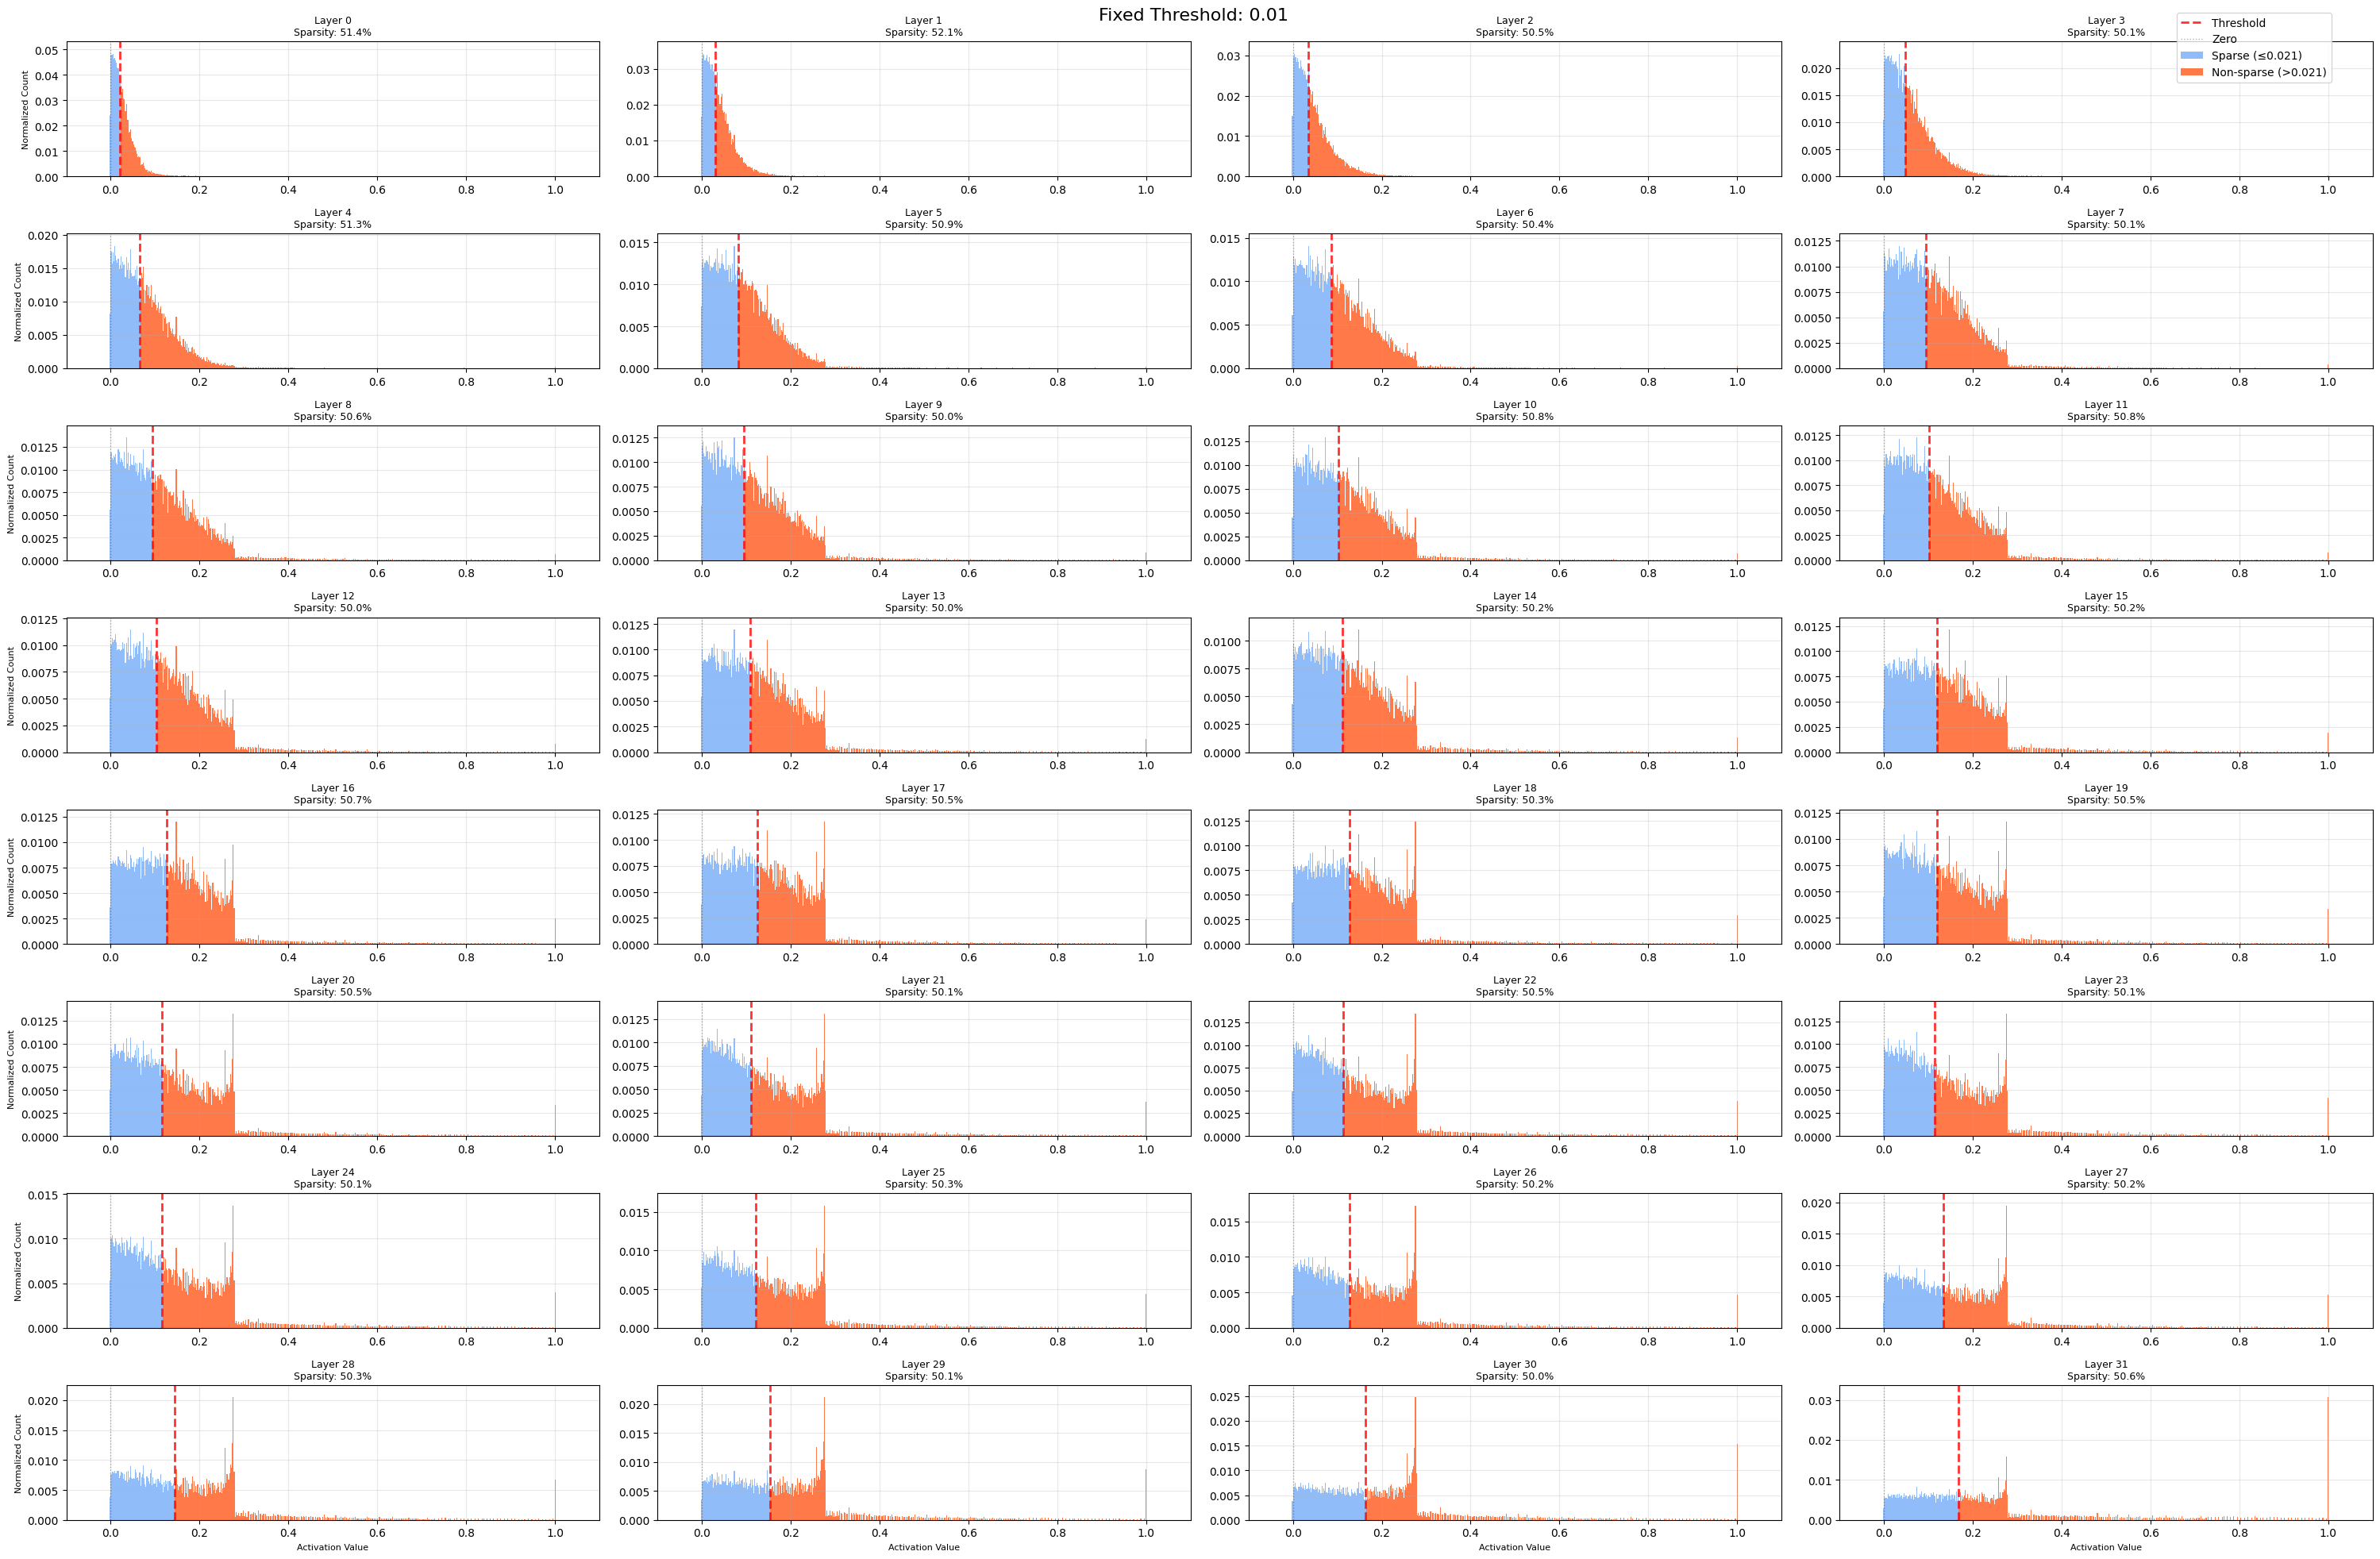


Threshold Summary (Target Sparsity: 50.0%):
  Layer 0: 0.021063
  Layer 1: 0.031093
  Layer 2: 0.035105
  Layer 3: 0.047141
  Layer 4: 0.065196
  Layer 5: 0.081244
  Layer 6: 0.087262
  Layer 7: 0.095286
  Layer 8: 0.093280
  Layer 9: 0.095286
  Layer 10: 0.103310
  Layer 11: 0.101304
  Layer 12: 0.103310
  Layer 13: 0.109328
  Layer 14: 0.111334
  Layer 15: 0.119358
  Layer 16: 0.125376
  Layer 17: 0.125376
  Layer 18: 0.127382
  Layer 19: 0.119358
  Layer 20: 0.115346
  Layer 21: 0.111334
  Layer 22: 0.113340
  Layer 23: 0.113340
  Layer 24: 0.115346
  Layer 25: 0.121364
  Layer 26: 0.127382
  Layer 27: 0.133400
  Layer 28: 0.143430
  Layer 29: 0.153460
  Layer 30: 0.163490
  Layer 31: 0.167503


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Dict, Any, Tuple, List, Union

def calculate_threshold_from_sparsity(
    bin_edges: torch.Tensor,
    histogram_counts: torch.Tensor,
    target_sparsity: float,
    verbose: bool = False
) -> float:
    """
    根据目标稀疏度计算阈值
    
    Args:
        bin_edges: 直方图区间边界
        histogram_counts: 各区间的计数
        target_sparsity: 目标稀疏度 (0-1之间)
        verbose: 是否打印调试信息
        
    Returns:
        threshold: 对应稀疏度的阈值
    """
    if not (0 <= target_sparsity <= 1):
        raise ValueError(f"target_sparsity must be between 0 and 1, got {target_sparsity}")
    
    # 计算累积概率
    total_count = histogram_counts.sum()
    normalized_counts = histogram_counts / total_count
    cumulative_prob = torch.cumsum(normalized_counts, dim=0)
    
    if verbose:
        print(f"Total count: {total_count}")
        print(f"Target sparsity: {target_sparsity:.2%}")
    
    # 使用 searchsorted 找到累积概率刚好超过目标稀疏度的位置
    # 注意：对于激活值，稀疏度通常指接近零的值的比例
    target_cumulative_prob = torch.tensor(target_sparsity)
    threshold_idx = torch.searchsorted(cumulative_prob, target_cumulative_prob, right=False)
    
    # 边界检查
    threshold_idx = torch.clamp(threshold_idx, 0, len(bin_edges) - 2)
    
    # 获取对应的阈值
    threshold = bin_edges[threshold_idx].item()
    
    if verbose:
        actual_sparsity = cumulative_prob[threshold_idx].item()
        print(f"Threshold index: {threshold_idx}")
        print(f"Calculated threshold: {threshold:.6f}")
        print(f"Actual sparsity at threshold: {actual_sparsity:.2%}")
    
    return threshold


def plot_all_layers_histogram(
    act_dict: Dict[int, Any],
    layer_indices: Optional[List[int]] = None,
    threshold: Optional[float] = None,
    target_sparsity: Optional[float] = None,
    within_color: str = "#227CF6",
    outside_color: str = "#FF6B35", 
    within_alpha: float = 0.5,
    outside_alpha: float = 0.9,
    threshold_color: str = "#FF0000",
    threshold_alpha: float = 0.8,
    zero_line_alpha: float = 0.3,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (20, 15),
    show_legend: bool = True,
    show_plot: bool = True,
    title: Optional[str] = None,
    xlabel: str = "Activation Value",
    ylabel: str = "Normalized Count",
    bin_edges_idx: int = 0,
    histogram_counts_idx: int = 2,
    max_cols: int = 8,
    show_threshold_lines: bool = True,
    verbose: bool = True
) -> Tuple[plt.Figure, np.ndarray]:
    """
    绘制所有层的激活值直方图作为子图，支持基于稀疏度的动态阈值
    
    Args:
        act_dict: 包含激活统计信息的字典 {layer_idx: layer_data}
        layer_indices: 要绘制的层索引列表，如果为None则绘制所有层
        threshold: 固定阈值，如果提供则忽略target_sparsity
        target_sparsity: 目标稀疏度 (0-1)，用于动态计算阈值
        within_color: 阈值内激活值的颜色
        outside_color: 阈值外激活值的颜色
        within_alpha: 阈值内激活值的透明度
        outside_alpha: 阈值外激活值的透明度
        threshold_color: 阈值线的颜色
        threshold_alpha: 阈值线的透明度
        zero_line_alpha: 零线的透明度
        xlim: x轴显示范围
        ylim: y轴显示范围
        figsize: 图片大小
        show_legend: 是否显示图例
        show_plot: 是否显示图片
        title: 总标题
        xlabel: x轴标签
        ylabel: y轴标签
        bin_edges_idx: bin_edges在layer_data中的索引
        histogram_counts_idx: histogram_counts在layer_data中的索引
        max_cols: 每行最大列数
        show_threshold_lines: 是否显示阈值线
        verbose: 是否打印调试信息
        
    Returns:
        fig, axes: matplotlib的图形和轴对象数组
    """
    
    # 参数验证
    if threshold is None and target_sparsity is None:
        threshold = 0.0  # 默认阈值
    elif threshold is not None and target_sparsity is not None:
        print("Warning: Both threshold and target_sparsity provided. Using fixed threshold.")
    
    # 确定要绘制的层
    if layer_indices is None:
        layer_indices = sorted(act_dict.keys())
    else:
        missing_layers = [idx for idx in layer_indices if idx not in act_dict]
        if missing_layers:
            raise ValueError(f"Layers not found in act_dict: {missing_layers}")
    
    total_layers = len(layer_indices)
    
    if verbose:
        print(f"Total layers to plot: {total_layers}")
        print(f"Layer indices: {layer_indices}")
    
    # 计算子图布局
    n_cols = min(max_cols, total_layers)
    n_rows = (total_layers + n_cols - 1) // n_cols
    
    if verbose:
        print(f"Grid layout: {n_rows} rows × {n_cols} cols")
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 处理单个子图的情况
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 存储每层的阈值信息
    layer_thresholds = {}
    
    # 绘制每个层的直方图
    for plot_idx, layer_idx in enumerate(layer_indices):
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col]
        
        try:
            # 提取层数据
            layer_data = act_dict[layer_idx]
            bin_edges = layer_data[bin_edges_idx]
            histogram_counts = layer_data[histogram_counts_idx]
            
            # 归一化
            normalized_counts = histogram_counts / histogram_counts.sum()
            
            # 计算当前层的阈值
            if threshold is not None:
                current_threshold = threshold
            else:
                current_threshold = calculate_threshold_from_sparsity(
                    bin_edges, histogram_counts, target_sparsity, 
                    verbose=(verbose and plot_idx == 0)  # 只在第一个图时打印详细信息
                )
            
            layer_thresholds[layer_idx] = current_threshold
            
            # 计算阈值内外的mask
            within_threshold_mask = bin_edges[:-1] <= current_threshold
            outside_threshold_mask = ~within_threshold_mask
            
            # 绘制阈值内的激活值（稀疏部分）
            if within_threshold_mask.any():
                within_counts = normalized_counts.clone()
                within_counts[outside_threshold_mask] = 0
                
                ax.bar(
                    bin_edges[:-1],
                    within_counts,
                    width=2/len(normalized_counts),
                    color=within_color,
                    alpha=within_alpha,
                    label=f"Sparse (≤{current_threshold:.3f})" if plot_idx == 0 else "",
                )
            
            # 绘制阈值外的激活值（非稀疏部分）
            if outside_threshold_mask.any():
                outside_counts = normalized_counts.clone()
                outside_counts[within_threshold_mask] = 0
                
                ax.bar(
                    bin_edges[:-1],
                    outside_counts,
                    width=2/len(normalized_counts),
                    color=outside_color,
                    alpha=outside_alpha,
                    label=f"Non-sparse (>{current_threshold:.3f})" if plot_idx == 0 else "",
                    clip_on=False,
                )
            
            # 绘制阈值线
            if show_threshold_lines and current_threshold != 0:
                ax.axvline(
                    x=current_threshold,
                    color=threshold_color,
                    alpha=threshold_alpha,
                    linestyle="--",
                    linewidth=2,
                    label=f"Threshold" if plot_idx == 0 else "",
                )
            
            # 绘制零线
            ax.axvline(
                x=0,
                color="black",
                alpha=zero_line_alpha,
                linestyle=":",
                linewidth=1,
                label="Zero" if plot_idx == 0 else ""
            )
            
            # 计算实际稀疏度用于显示
            total_count = histogram_counts.sum()
            sparse_count = histogram_counts[within_threshold_mask].sum()
            actual_sparsity = sparse_count / total_count
            
        except Exception as e:
            if verbose:
                print(f"Error plotting layer {layer_idx}: {e}")
            ax.text(0.5, 0.5, f"Error\nLayer {layer_idx}", 
                   ha='center', va='center', transform=ax.transAxes)
            normalized_counts = np.array([0, 1])
            actual_sparsity = 0
            current_threshold = 0
        
        # 设置子图属性
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(0, normalized_counts.max() * 1.1)
        
        # 标题包含稀疏度信息
        ax.set_title(f"Layer {layer_idx}\nSparsity: {actual_sparsity:.1%}", fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # 只在边缘子图显示轴标签
        if row == n_rows - 1:
            ax.set_xlabel(xlabel, fontsize=8)
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=8)
    
    # 隐藏多余的子图
    for idx in range(total_layers, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # 设置总标题
    if title:
        fig.suptitle(title, fontsize=16)
    else:
        if target_sparsity is not None:
            fig.suptitle(f"Activation Histograms - Target Sparsity: {target_sparsity:.1%}", fontsize=16)
        else:
            fig.suptitle(f"Activation Histograms - Fixed Threshold: {threshold}", fontsize=16)
    
    # 设置图例
    if show_legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    # 打印阈值摘要
    if verbose and target_sparsity is not None:
        print(f"\nThreshold Summary (Target Sparsity: {target_sparsity:.1%}):")
        for layer_idx in sorted(layer_thresholds.keys()):
            print(f"  Layer {layer_idx}: {layer_thresholds[layer_idx]:.6f}")
    
    return fig, axes


# 使用示例
if __name__ == "__main__":
    # 加载数据
    act_dict = torch.load("/home/fit/renju/WORK/lxm/CATS/t_res/general_finetuning/sparse_llama_7b_hf/refined_web_activation_histogram.pt")
    
    # 使用固定阈值
    fig, axes = plot_all_layers_histogram(
        act_dict,
        target_sparsity=0.5,
        xlim=(-0.1, 1.1),
        figsize=(30, 20),
        max_cols=4,
        title="Target Threshold: 0.5"
    )
    
    # # 使用基于稀疏度的动态阈值
    # fig, axes = plot_all_layers_histogram(
    #     act_dict,
    #     target_sparsity=0.5,  # 50% 稀疏度
    #     xlim=(-0.1, 1.1),
    #     figsize=(25, 20),
    #     max_cols=8,
    #     title="Dynamic Threshold for 50% Sparsity"
    # )
    
    # # 绘制指定层，使用 80% 稀疏度
    # selected_layers = [0, 5, 10, 15, 20, 25, 30]
    # fig, axes = plot_all_layers_histogram(
    #     act_dict,
    #     layer_indices=selected_layers,
    #     target_sparsity=0.5,
    #     xlim=(-0.1, 1.1),
    #     figsize=(30, 10),
    #     max_cols=4,
    #     title="Selected Layers - 50% Sparsity"
    # )

In [268]:
layer_idx = 30
test = act_dict[layer_idx][2]/act_dict[layer_idx][2].sum()  # 归一化
print(test[-1])

tensor(0.0154)
